In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
# train = pd.read_csv("data/train.csv")
# top1 = train[train.item_nbr == 265559 ]
DIR="..\\..\\chunk\\15\\"
top1=pd.read_csv(f'{DIR}train103501.csv')
top1['date'] = pd.to_datetime(top1['date'])
top1['year'] = top1['date'].dt.year

#### Подготовим данные

In [3]:
unit_sales_by_date = top1.groupby('date').sum()['unit_sales']

#### Импортируем метрики

In [5]:
%pip install sklearn

  Using cached https://files.pythonhosted.org/packages/1e/7a/dbb3be0ce9bd5c8b7e3d87328e79063f8b263b2b1bfa4774cb1147bfcd3f/sklearn-0.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/3e/d5/0163eb0cfa0b673aa4fe1cd3ea9d8a81ea0f32e50807b0c295871e4aab2e/joblib-1.1.0-py2.py3-none-any.whl
  Running setup.py install for sklearn: started
    Running setup.py install for sklearn: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

### Тест Адфуллера для проверки стационарных временных рядов

In [7]:
from statsmodels.tsa.stattools import adfuller

X = unit_sales_by_date.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -4.154403
p-value: 0.000786
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Reject Ho - Time Series is Stationary


## Модель скользящего среднего

(1619,) (1625,)
mean_squared_error 1139.483889232036
mean_absolute_error 26.661828289067326
mean_absolute_percentage_error 0.326732641949257


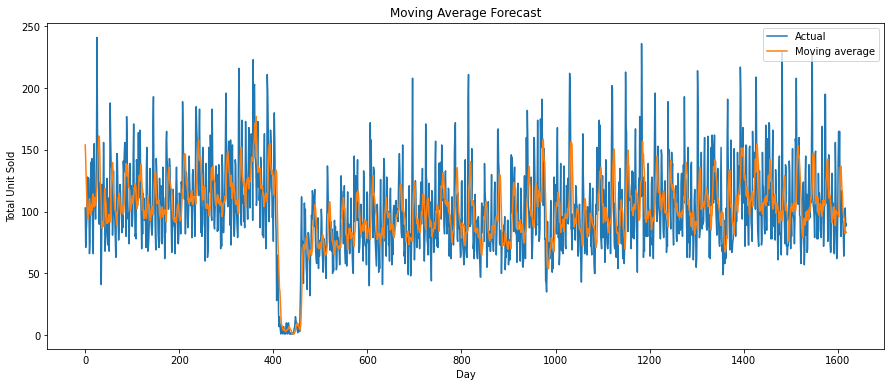

In [8]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
moving_average_days = 6
moving_avg = moving_average_forecast(unit_sales_by_date,moving_average_days )# 

print(moving_avg.shape,unit_sales_by_date.shape)

print("mean_squared_error",mean_squared_error(unit_sales_by_date.values[moving_average_days:], moving_avg))
print("mean_absolute_error",mean_absolute_error(unit_sales_by_date.values[moving_average_days:], moving_avg))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(unit_sales_by_date.values[moving_average_days:], moving_avg))


plt.figure(figsize=(15,6))

plt.plot(unit_sales_by_date.values[moving_average_days:], label="Actual")
plt.plot(moving_avg, label="Moving average")
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Moving Average Forecast")
plt.legend(loc="upper right")

In [9]:
x_train = unit_sales_by_date['2013':'2016'].values
x_test  = unit_sales_by_date['2017'].values

df = pd.DataFrame()

df["Original Values"]  = unit_sales_by_date
df["shift1"] = df["Original Values"].shift()
df["shift2"] = df["shift1"].shift()
df["shift3"] = df["shift2"].shift()
df["shift4"] = df["shift3"].shift()
df["shift5"] = df["shift4"].shift()
df["shift6"] = df["shift5"].shift()


lag_value = 6
df.dropna(inplace=True)


x_train, y_train = df['2013':'2016'].iloc[:,0:lag_value].values, df['2013':'2016'].iloc[:,lag_value:].values
x_test, y_test = df['2017'].iloc[:,0:lag_value].values, df['2017'].iloc[:,lag_value:].values

x_train

array([[103.,  98., 173., 160., 155., 153.],
       [ 71., 103.,  98., 173., 160., 155.],
       [ 83.,  71., 103.,  98., 173., 160.],
       ...,
       [115., 137., 116., 148., 103.,  92.],
       [114., 115., 137., 116., 148., 103.],
       [127., 114., 115., 137., 116., 148.]])

In [10]:
x_test.shape

(226, 6)

[[ 0.31483972 -0.06093726 -0.00835441 -0.02690103 -0.05841532  0.65215135]]
[18.74834312]
mean_squared_error 913.16126313651
mean_absolute_error 23.424632830450623
mean_absolute_percentage_error 0.21190002900141588


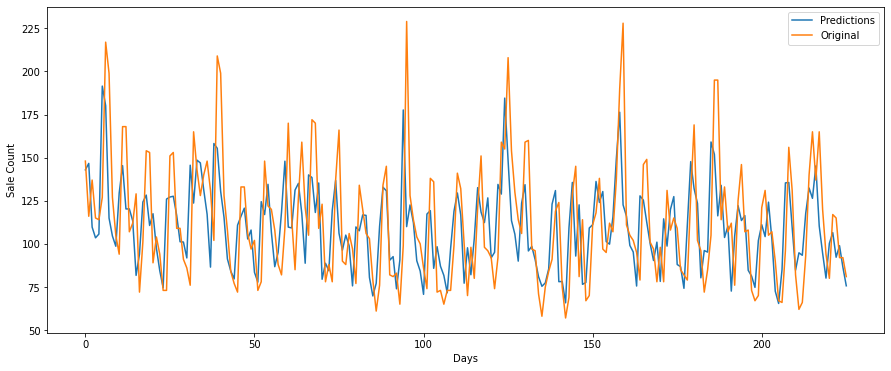

In [11]:

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)


ar_predictions = reg.predict(x_test)

plt.figure(figsize=(15,6))
plt.plot(ar_predictions ,label = "Predictions")
plt.plot(y_test, label = "Original" )
plt.xlabel("Days")
plt.ylabel("Sale Count")

print("mean_squared_error",mean_squared_error(y_test, ar_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, ar_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, ar_predictions))


plt.legend(loc="upper right")

Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 3-х параметров:
    
    p — порядок компоненты AR
    d — порядок интегрированного ряда
    q — порядок компонетны MA
    
d мы уже знаем - это 1

осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.

ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов.

In [12]:
unit_sales_by_date.values

array([185., 153., 155., ..., 103.,  88.,  90.])

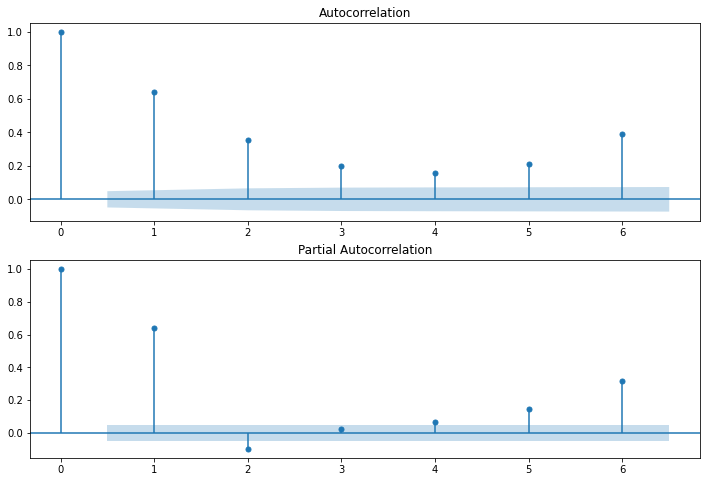

In [13]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(unit_sales_by_date.values.squeeze(), lags=6, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(unit_sales_by_date, lags=6, ax=ax2)

После изучения коррелограммы PACF можно сделать вывод, что p = 6, т.к. на ней все лаги сильно отличны от нуля.
По коррелограмме ACF можно предположить, что q = 6, т.к. на лаг 6 значении функций резко возрастает. Итак, когда известны все параметры можно построить модель.

## ARMA Model

In [18]:
x_train

,Original Values,shift1,shift2,shift3,shift4,shift5
date,,,,,,
2013-01-08,103.0,98.0,173.0,160.0,155.0,153.0
2013-01-09,71.0,103.0,98.0,173.0,160.0,155.0
2013-01-10,83.0,71.0,103.0,98.0,173.0,160.0
2013-01-11,91.0,83.0,71.0,103.0,98.0,173.0
2013-01-12,118.0,91.0,83.0,71.0,103.0,98.0
...,...,...,...,...,...,...
2016-12-27,116.0,148.0,103.0,92.0,100.0,80.0
2016-12-28,137.0,116.0,148.0,103.0,92.0,100.0
2016-12-29,115.0,137.0,116.0,148.0,103.0,92.0


In [17]:
x_train.values.reshape(-1)

array([103.,  98., 173., ..., 137., 116., 148.])

In [20]:
len(x_train.values.reshape(-1)),len(x_train)

(8358, 1393)

mean_squared_error 3255.80844629627
mean_absolute_error 47.097622833954965
mean_absolute_percentage_error 0.4688682315189251


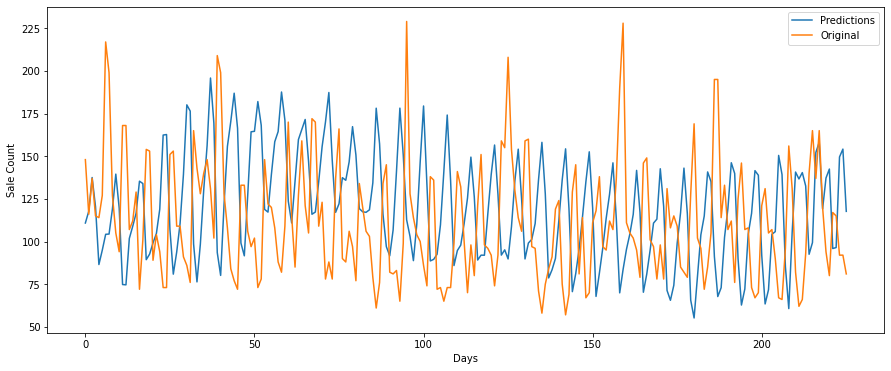

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from datetime import datetime, timedelta

x_train, y_train = df['2013':'2016'].iloc[:,0:lag_value], df['2013':'2016'].iloc[:,lag_value:]
x_test, y_test = df['2017'].iloc[:,0:lag_value], df['2017'].iloc[:,lag_value:]

ARMA_model = ARMA(x_train.values.reshape(-1).tolist(), (6,6)).fit()
arma_predictions = ARMA_model.predict(start=len(x_train), end=len(x_train) + len(x_test)-1, dynamic=False)


plt.figure(figsize=(15,6))
plt.plot(arma_predictions ,label = "Predictions")
plt.plot(y_test.values, label = "Original" )
plt.xlabel("Days")
plt.ylabel("Sale Count")
plt.legend(loc="upper right")

print("mean_squared_error",mean_squared_error(y_test, arma_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, arma_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, arma_predictions))



## ARIMA model

In [21]:
x_train['Original Values'].values

array([103.,  71.,  83., ..., 115., 114., 127.])

In [15]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(x_train['Original Values'].values, (6,1,6)).fit()



/Users/y.mochalova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/y.mochalova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, n

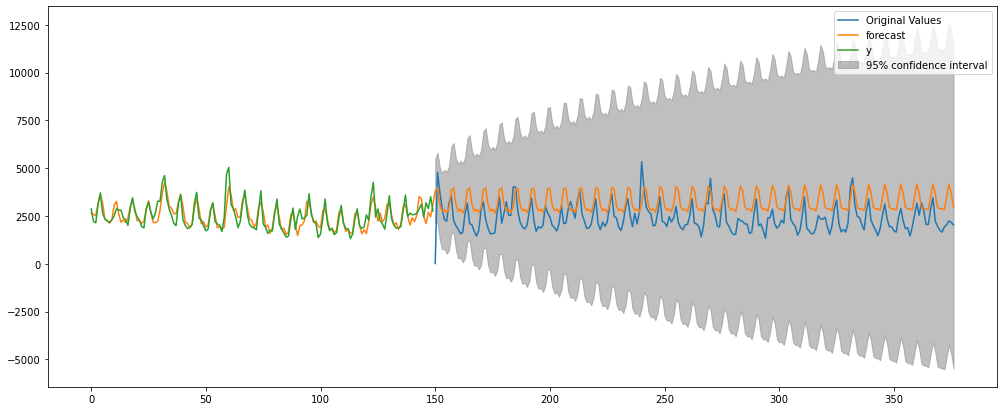

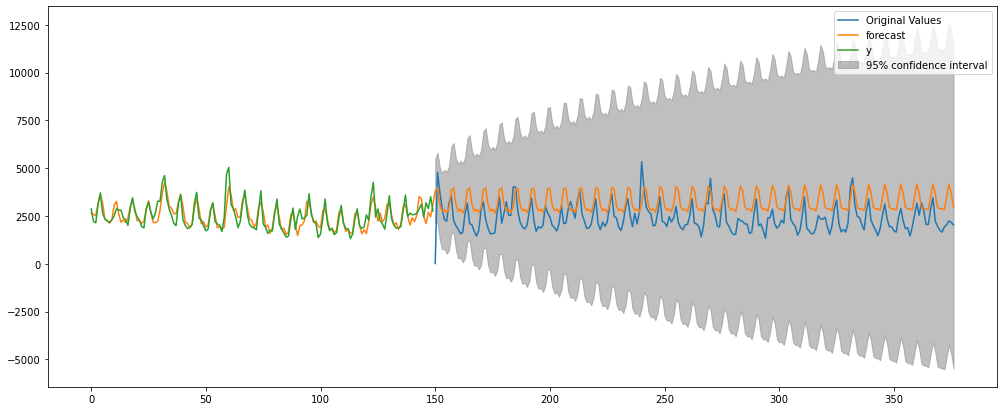

In [16]:
fig, ax = plt.subplots(figsize=(17,7))
shown_train_size = 150
train_size = len(x_train['Original Values'].values)
test_size = len(x_test['Original Values'].values) 
ax = x_test.set_index(pd.Series(range(shown_train_size, shown_train_size + test_size)))['Original Values'].plot(ax=ax)
model.plot_predict(start=train_size-shown_train_size,end=train_size+test_size -1,dynamic=False, plot_insample=True,ax=ax)

In [17]:
arima_predictions = model.predict(train_size, train_size + test_size -1)
print("mean_squared_error",mean_squared_error(y_test, arima_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, arima_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, arima_predictions))



mean_squared_error 6341053.474301653
mean_absolute_error 2410.363945568809
mean_absolute_percentage_error 1.099329007456299
